# DBS/TMS awake/asleep comparison- Consciousness

## Freesurfer Reconstruction and Source Space using MNE-C

## Load data into MEEGbuddy

In [2]:
import os,re,glob
import os.path as op
from MEEGbuddy import MEEGbuddy
from MEEGbuddy.bv2fif import bv2fif
import numpy as np
from mne import find_events, events_from_annotations
from mne.io import Raw
import matplotlib.pyplot as plt
from pandas import DataFrame

subject = 'PT'
session = '20190726'
ref_ch = None
event_id = 'Stimulus/S255' #'TMS' #'Response/R 15'
perturbation = 'TMS'

datarex = re.compile(r'[%s|%s]*.vhdr' % (subject.lower(), subject.upper()))
correx = re.compile(r'[%s|%s]*.csv' % (subject.lower(), subject.upper()))
    
this_dir = op.join('data', perturbation, subject, session)
files = os.listdir(this_dir)
if not files:
    print('Subject data must be in a folder with their name')
corf = None
for f in files:
    if correx.search(op.basename(f)):
        corf = f
for f in files:
    if all([datarex.search(f),not 'fif' in f,not 'avg' in f, 
            not '-TMS.vhdr' == op.basename(f)[-9:],not '-DBS.vhdr' == op.basename(f)[-9:]]):
        fdata = (op.join(this_dir, op.dirname(f),
                 op.basename(f).split('.')[0]+'-raw.fif'))
        behavior = op.join(this_dir, op.dirname(f),
                 op.basename(f).split('.')[0]+'.csv')
        if not op.isfile(fdata):
            bv2fif(op.join(this_dir, f), op.join(this_dir, corf),
                   ref_ch=ref_ch, dbs=perturbation.lower()=='dbs')
        raw = Raw(fdata, preload=False)
        events, event_id2 = events_from_annotations(raw)
        if not events.size > 0:
            events = find_events(raw)
        if len(np.unique(events[:, 2])) > 1:
            events = events[np.where(events[:,2] == events[1,2])[-1]] #skip new segment
        df = DataFrame({'Trial': range(1, events.shape[0] + 1), 'State': 'TBD'})
        df.to_csv(behavior, index=False)
        behavior_description = {'Trial': {'Description': 'The order of the stimulus presentations',
                                          'Baseline': {'Channel': event_id, 'Time Min': -0.4, 'Time Max': -0.01},
                                          'Events': {perturbation: {'Channel': event_id, 'Time Min': -0.5, 'Time Max': 1.0}},
                                          'Exclude Trials': [0, len(df) - 1]},
                                'State': {'Description': 'Whether the subject was awake or asleep on ' + 
                                          'that trial'}}
        #
        fs_dir = op.join(os.getcwd(), 'data', perturbation)
        bemf = op.join(fs_dir,subject, 'bem', '%s-5120-5120-5120-bem-sol.fif' % (subject))
        srcf = op.join(fs_dir,subject, 'bem', '%s-oct-6-src.fif' % (subject))
        transf = op.join(fs_dir, subject, session, 'COR-%s_%s.fif' % (subject, session))
        #
        print('Loading in to MEEGbuddy %s %s' %(subject, session))
        data = MEEGbuddy(subject=subject, session=session, fdata=fdata,
                         task=perturbation + 'EEG', eeg=True,
                         subjects_dir=op.join(os.getcwd(), 'data'),
                         fs_subjects_dir=fs_dir,
                         bemf=bemf, srcf=srcf, transf=transf, behavior=behavior,
                         behavior_description=behavior_description)

Opening raw data file data/TMS/PT/20190726/TMS_EEG_PT_20170726_2IPI_Premotor-raw.fif...
    Range : 0 ... 2407999 =      0.000 ...   481.600 secs
Ready.
Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S127', 'Stimulus/S255']
Loading in to MEEGbuddy PT 20190726


In [ ]:
from MEEGbuddy import recon_subject, setup_source_space
import os.path as op
import os

subject = 'PT'
session = '20190726'
perturbation = 'TMS'
fs_dir = op.join(os.getcwd(), 'data', perturbation)

recon_subject(subject, fs_dir, 
              t1f=op.join('data', 'anat', subject, 'T1.mgz'))
setup_source_space(subject, fs_dir, 
                   flash=op.join('data', 'anat', subject, 'flash'))
# Note: be sure to copy the automatically generated transform file 
# fs_subjects_dir/mri/T1-neuromag/sets/COR-{username}-{date}.fif
# to fs_subjects_dir/subject/session/COR-{subject}_{session}.fif

# Reload MEEGbuddy

In [2]:
from MEEGbuddy import loadMEEGbuddy
import os.path as op
import os

subject = 'PT'
session = '20190726'
perturbation = 'TMS'

data = loadMEEGbuddy(op.join(os.getcwd(), 'data'), subject, session,
                     eeg=True, task=perturbation + 'EEG')

# Save to BIDS

In [3]:
data.save2BIDS('data_BIDS')

Loading Raw file(s)
data/TMS/PT/20190726/TMS_EEG_PT_20170726_2IPI_Premotor-raw.fif
File saved for Raw bids 
File loaded for Raw bids 
Creating folder: data_BIDS/sub-PT/ses-20190726/eeg

Writing 'data_BIDS/participants.tsv'...

participant_id	age	sex
sub-PT	n/a	n/a

Writing 'data_BIDS/participants.json'...

{
    "participant_id": {
        "Description": "Unique participant identifier"
    },
    "age": {
        "Description": "Age of the participant at time of testing",
        "Units": "years"
    },
    "sex": {
        "Description": "Biological sex of the participant",
        "Levels": {
            "F": "female",
            "M": "male"
        }
    }
}

Writing 'data_BIDS/sub-PT/ses-20190726/sub-PT_ses-20190726_scans.tsv'...

filename	acq_time
eeg/sub-PT_ses-20190726_task-TMSEEG_run-01_eeg.fif	2019-07-26T08:31:14

Writing 'data_BIDS/dataset_description.json'...

{
    "Name": " ",
    "BIDSVersion": "1.2.0"
}


/Users/alexrockhill/.local/lib/python3.6/site-packages/mne_bids-0.2.dev0-py3.6.egg/mne_bids/utils.py:287: UserWarning: No events found or provided. Please make sure to set channel type using raw.set_channel_types or provide events_data.
  warnings.warn('No events found or provided. Please make sure to'
/Users/alexrockhill/.local/lib/python3.6/site-packages/mne_bids-0.2.dev0-py3.6.egg/mne_bids/write.py:405: UserWarning: No line frequency found, defaulting to 50 Hz
  warn('No line frequency found, defaulting to 50 Hz')



Writing 'data_BIDS/sub-PT/ses-20190726/eeg/sub-PT_ses-20190726_task-TMSEEG_run-01_eeg.json'...

{
    "TaskName": "TMSEEG",
    "Manufacturer": "Elekta",
    "PowerLineFrequency": 50,
    "SamplingFrequency": 5000.0,
    "SoftwareFilters": "n/a",
    "RecordingDuration": 481.5998,
    "RecordingType": "continuous",
    "EEGReference": "n/a",
    "EEGGround": "n/a",
    "EEGPlacementScheme": "based on the extended 10/20 system",
    "EEGChannelCount": 64,
    "EOGChannelCount": 0,
    "ECGChannelCount": 0,
    "EMGChannelCount": 0,
    "MiscChannelCount": 0,
    "TriggerChannelCount": 0
}

Writing 'data_BIDS/sub-PT/ses-20190726/eeg/sub-PT_ses-20190726_task-TMSEEG_run-01_channels.tsv'...

name	type	units	low_cutoff	high_cutoff	description	sampling_frequency	status
Fp1	EEG	V	0.0	1000.0	ElectroEncephaloGram	5000.0	good
Fpz	EEG	V	0.0	1000.0	ElectroEncephaloGram	5000.0	good
Fp2	EEG	V	0.0	1000.0	ElectroEncephaloGram	5000.0	good
AF7	EEG	V	0.0	1000.0	ElectroEncephaloGram	5000.0	good
AF3	EEG	V	

## Channel and Trial Rejection

In [2]:
%matplotlib

import matplotlib.pyplot as plt

event = 'TMS' if data.task == 'TMSEEG' else 'DBS'

data.makeEpochs(keyword_out='Preprocessed', overwrite=True)
#data.filterEpochs(event, keyword_in='Preprocessed', l_freq=None, h_freq=40, overwrite=True)
data.plotEvoked(event, keyword='Preprocessed', ylim={'eeg':[-60, 40]},
                tmin=-0.5, tmax=0.5)
ok, first = False, True
while not ok:
    data.plotRaw(keyword_in=(None if first else 'Preprocessed'),
                 keyword_out='Preprocessed', l_freq=None, h_freq=None, overwrite=True)
    data.makeEpochs(keyword_in='Preprocessed', overwrite=True)
    #data.filterEpochs(event, keyword_in='Preprocessed', l_freq=None, h_freq=40, overwrite=True)
    data.plotEvoked(event, keyword='Preprocessed', ylim={'eeg':[-60,40]}, tmin=-0.5, tmax=0.5)
    ok, first = input('Type Y or y if ok, anything else to go back\n').lower() == 'y', False
#
ok = False
while not ok:
    raw_interp,_ = data.plotInterpolateArtifact(event, keyword='Preprocessed', mode='spline', 
                                                npoint_art=126, offset=25, tmin=-0.1, tmax=0.1, 
                                                ylim=[-1e-4,1e-4])
    plt.show()
    ok = input('Type Y or y if ok, anything else to go back\n').lower() == 'y'
#
data.applyInterpolation(raw_interp, keyword_out='Interpolated',
                        overwrite=True)
data.filterRaw(keyword_in='Interpolated', l_freq=1.0, overwrite=True)
data.makeEpochs(keyword_in='Interpolated', keyword_out='Preprocessed', overwrite=True)
data.downsample(event=event, keyword_in='Preprocessed', new_sfreq=200, overwrite=True)
#
ok = False
while not ok:
    data.plotEvoked(event, keyword='Preprocessed', 
                    ylim={'eeg':[-60, 40]}, tmin=-0.5, tmax=0.5)
    data.plotEpochs(event, keyword_in='Preprocessed', 
                    l_freq=None, h_freq=None, overwrite=True)
    ok = input('Type Y or y if ok, anything else to go back\n').lower() == 'y'

Using matplotlib backend: TkAgg
Loading Raw file(s)
data/TMS/PT/20190726/TMS_EEG_PT_20170726_2IPI_Premotor-raw.fif
Baseline events found: 200
File saved for Epochs Baseline Preprocessed 
Overwriting existing file.
File loaded for Epochs Baseline Preprocessed 
TMS events found: 200
File saved for Epochs TMS Preprocessed 
Overwriting existing file.
Normalizing epochs based on baseline
File loaded for Epochs TMS Preprocessed 
File saved for Epochs TMS Preprocessed 
Overwriting existing file.
File loaded for Epochs TMS Preprocessed 
Loading Raw file(s)
data/TMS/PT/20190726/TMS_EEG_PT_20170726_2IPI_Premotor-raw.fif
File saved for Raw Preprocessed 
File loaded for Raw Preprocessed 
Baseline events found: 200
File saved for Epochs Baseline Preprocessed 
Overwriting existing file.
File loaded for Epochs Baseline Preprocessed 
TMS events found: 200
File saved for Epochs TMS Preprocessed 
Overwriting existing file.
Normalizing epochs based on baseline
File loaded for Epochs TMS Preprocessed 
Fil

## ICA

In [ ]:
%matplotlib

import matplotlib.pyplot as plt

event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
# precompute ICA
data.findICA(event=event, keyword_in='Preprocessed', keyword_out='ICA',
             n_components=0.95, overwrite=True, overwrite_ica=True)
#
data.filterEpochs(event, h_freq=40, keyword_in='Preprocessed', keyword_out='Vis', overwrite=True)
data.plotEvoked(event, keyword='Vis', ylim={'eeg':[-100, 100]})
data.plotTopo(event, keyword='Vis')
ok = False
while not ok:
    data.plotICA(event=event, keyword_in='Preprocessed', keyword_out='ICA')
    data.filterEpochs(event, h_freq=40, keyword_in='ICA', keyword_out='Vis', overwrite=True)
    data.plotEvoked(event, keyword='Vis', ylim={'eeg':[-100, 100]})
    data.plotTopo(event, keyword='Vis')
    ok = input('Type Y or y if ok, anything else to go back\n').lower() == 'y'
plt.show()
data.filterEpochs(event, h_freq=80, keyword_in='ICA', overwrite=True)
epochs = data._load_epochs(event, keyword='ICA')
bl_epochs = epochs.crop(tmin=data.baseline[1], tmax=data.baseline[2])
data._save_epochs(bl_epochs, 'Baseline', keyword='ICA')

File loaded for Epochs TMS Preprocessed 
Using no channels as eogs
Using no channels as ecgs
eeg
File saved for ICA TMS eeg ICA 
No eog, ecg or stim channels No channels match the selection.
File saved for Epochs TMS ICA 
File loaded for Epochs TMS Preprocessed 
File saved for Epochs TMS Vis 
File loaded for Epochs TMS Vis 
File loaded for Epochs TMS Vis 
File loaded for Epochs TMS Preprocessed 
Using no channels as eogs
Using no channels as ecgs
File loaded for ICA TMS eeg ICA 


## Multitaper Spectrogram and Sleep/Wake Assignment

In [ ]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
state_times = data.psdMultitaper(keyword='Preprocessed', overwrite=False, ch='Oz', vmax=-10)
data.assignConditionFromStateTimes(event, state_times)

## Clean Up

In [ ]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
data.remove(keyword='Preprocessed')
data.remove(event, keyword='Preprocessed')
data.remove(keyword='Interpolated')

## Source Space

In [3]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
data.epochs2source(event, 'State', method='MNE', snr=1.0, 
                   keyword_in='ICA', keyword_out='Clean', 
                   overwrite=True)

File loaded for Epochs TMS ICA 
File loaded for Epochs Baseline ICA 
Making forward model...
Making inverse for all...
File saved for Inverse TMS State all Clean 
Making inverse for TBD...
File saved for Inverse TMS State TBD Clean 
Applying inverse for TBD
File saved for Source Estimate TMS State TBD Clean 


### Plot Source Space (optional)

In [ ]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
data.plotSourceSpace(event,'State', keyword='Clean', tmin=-0.1, tmax=0.5)
plt.close('all')

## PCI

The interesting part!

In [4]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
if not data._has_epochs(event, keyword='PCI'):
    values = [value for value in data._default_values('State') if not value == 'Neither']
    alphas = [0.01] if event == 'TMS' else [0.01, 0.1, 0.5]
    if not all([data._has_noreun_PCI(event, 'State', value, keyword='alpha=%s' %(alpha)) 
                for value in values for alpha in alphas]):
        for alpha in alphas:
            print('Alpha = %s' %(alpha))
            data.noreunPhi(event, 'State', values=values, keyword_in='ICA', source_keyword='Clean',
                           keyword_out='alpha=%s' % alpha, alpha=alpha, npoint_art=4,
                           tmin=0.0, tmax=0.3, shared_baseline=False,
                           bl_tmin=-0.4, bl_tmax=-0.01, downsample=False,
                           recalculate_PCI=True, recalculate_baseline=True)

Alpha = 0.01
File loaded for Epochs TMS ICA 
Running baseline bootstrap for TBD


100%|██████████| 480/480 [01:28<00:00,  6.50it/s]


File saved for Bootstrap Threshold TMS State TBD alpha=0.01 
File loaded for Bootstrap Threshold TMS State TBD alpha=0.01 
Running Lempel-Ziv compression for TBD
Computing LZ complexity...
Computing the normalization factor...
Done.
File saved for PCI TMS State TBD alpha=0.01 


### Plot PCI

File loaded for PCI TMS State TBD alpha=0.01 
File loaded for Bootstrap Threshold TMS State TBD alpha=0.01 


/Users/alexrockhill/software/anaconda3/lib/python3.6/site-packages/MEEGbuddy-0.0-py3.6.egg/MEEGbuddy/MEEGbuddy.py:1604: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


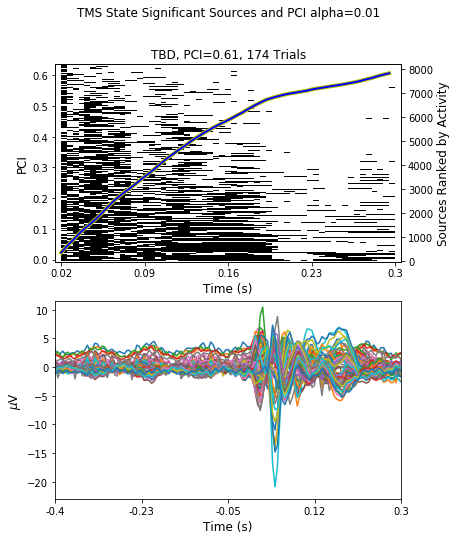

In [5]:
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
values = [value for value in data._default_values('State') if not value == 'Neither']
alphas = [0.01] if event == 'TMS' else [0.01, 0.1, 0.5]
for alpha in alphas:
    data.plotNoreunPCI(event, 'State', values=values, keyword='alpha=%s' %(alpha),
                       evoked_tmin=-0.4, evoked_tmax=0.3)

## Wavelet Connectivity Visualization (not part of pipeline)

In [ ]:
import matplotlib.pyplot as plt

print(data.subject + ' ' + data.session)
event = 'TMS' if data.task == 'TMSEEG' else 'DBS'
data.waveletConnectivity(event,'State',keyword_in='Clean',
                         keyword_out='WC',downsample=False,
                         bands={'alpha':(8, 15),'beta':(15, 35),
                                'gamma':(35, 150)},tmin=-0.5,tmax=1,
                         time_scalar=2, vis_tmin=-0.1, vis_tmax=0.2,
                         threshold=0.5)
plt.close('all')